# ArchiveTeam Ingest Rate

This notebook shows how to chart the growth of the ArchiveTeam collection at the Internet Archivee over time. It relies on using the [iacoll](https://github.com/edsu/iacoll) utility to download all the item metadata for the ArchiveTeam collection, and then using that collected metadata to generate some charts.

To get the metadata you'll need to run this command for a few days:

    % iacoll archiveteam
    
Once it finishes we can write a function to iterate over all the metadata in the LevelDB database, and populate the *sizes* dictionary that has the date as a key, and the size of the files uploaded that day in bytes as a value.

In [1]:
import os
import re
import json
import plyvel

def get_sizes():
    db = plyvel.DB('archiveteam')
    sizes = {}

    for k, v in db:
        item_id = k.decode('utf8')                 
        if not item_id.startswith('iacoll:item:'):
            continue

        item = json.loads(v)
        if 'files' not in item or 'addeddate' not in item['metadata']:
            continue
            
        size = 0
        for file in item['files']:
            if 'size' in file:
                size += int(file['size'])
            
        m = re.match('(^\d\d\d\d-\d\d-\d\d)', item['metadata']['addeddate'])
        date = m.group(1)
    
        sizes[date] = sizes.get(date, 0) + size
    
    db.close()
    return sizes    

If we don't have it already we need to use our *get_sizes* function to write out a CSV of dates and bytes uploaded to the ArchiveTeam collection on that day. Since it takes some time to iterate over this data we save it so it doesn't need to be recalcuated every time this notebook is run.

In [2]:
import csv

if not os.path.isfile('ArchiveTeam-sizes.csv'):
    
    sizes = get_sizes()
    dates = sorted(sizes.keys())

    with open('ArchiveTeam.csv', 'w') as output:
        writer = csv.writer(output)
        writer.writerow(['date', 'size'])
        for date in dates:
            writer.writerow([date, sizes[date]])

## Analyze the Data

So now we have our CSV of data we can analyze it a bit with [pandas](https://pandas.pydata.org/) and maybe generate a useful graph. First we'll import pandas and load in the data as a pandas DataFrame.

*Aside: I'm still learning pandas, and this is not meant to be a tutorial. If you want to learn more about all the amazing stuff you can do with it you'll want to spend some time in their excellent [tutorial](https://pandas.pydata.org/pandas-docs/stable/dsintro.html). If you work with R at all it should look pretty familiar. If not, treat this as just dipping your toe in to test the water. That's what I'm doing. If you do know pandas and notice a better way of doing any of this please let me know!*

In [3]:
import pandas as pd

sizes = pd.read_csv('ArchiveTeam.csv', index_col=0, parse_dates=True)
sizes.head()

,size
date,
2009-03-10,214577441
2009-03-12,214577249
2010-11-30,75503895
2011-03-21,3068211032
2011-04-04,1952767638


It looks like the liveweb data started saving back in 2011. So now we've got a DataFrame that is indexed by the day, with one Series *size* that contains the bytes. I don't know about you, but I find it difficult to think of size in terms of bytes. So let's use pandas to calcuate a gigabyte column for us using the bytes:

In [4]:
sizes = sizes.assign(gb=lambda x: x / 1024 ** 3)
sizes.head()

,size,gb
date,,
2009-03-10,214577441,0.199841
2009-03-12,214577249,0.199841
2010-11-30,75503895,0.070318
2011-03-21,3068211032,2.857494
2011-04-04,1952767638,1.818657


Now we can tell pandas to calcuate some statistics on our data:

In [5]:
sizes.describe()

,size,gb
count,2.471000e+03,2471.000000
mean,1.435572e+12,1336.980692
std,1.697634e+12,1581.045059
min,2.566200e+04,0.000024
25%,3.087655e+11,287.560266
50%,9.378079e+11,873.401690
75%,1.868169e+12,1739.868281
max,1.311028e+13,12209.895500


## Visualize the Data

Since we have thousands of days, it might be useful to see the stats by month rather than by day. That's not too hard to do since our dataframe as a date index and pandas support for [timeseries](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries) data allows us to resample the dataframe on a monthly basis:

In [6]:
sizes_by_month = sizes.resample('M').sum()
sizes_by_month.head()

,size,gb
date,,
2009-03-31,429154690,0.399681
2009-04-30,0,0.000000
2009-05-31,0,0.000000
2009-06-30,0,0.000000
2009-07-31,0,0.000000


Text(0.5, 1.0, 'ArchiveTeam Ingest Rate')

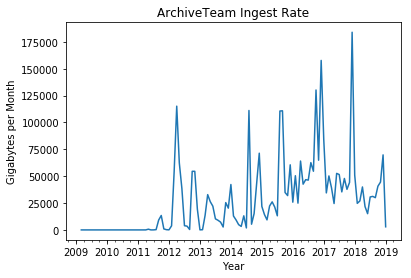

In [9]:
%matplotlib inline

plot = sizes_by_month['gb'].plot()
plot.set_xlabel('Year')
plot.set_ylabel('Gigabytes per Month')
plot.set_title('ArchiveTeam Ingest Rate')